In [51]:
import sys
from pathlib import Path
import math
import numpy as np
import matplotlib.pyplot as plt

# On suppose que le notebook est dans /notebooks
project_root = Path.cwd().parent
sys.path.append(str(project_root))


In [52]:

from src.pricers import mc_call_price_gbm

In [53]:
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def bs_call_price(S, K, T, r, sigma):
    d1 = (math.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return S * norm_cdf(d1) - K * math.exp(-r*T) * norm_cdf(d2)


In [54]:
S0 = 100
K  = 100
r  = 0.05
sigma = 0.2
T  = 1.0

seed = 42

N_list = [
    1_000, 2_000, 5_000,
    10_000, 20_000, 50_000,
    100_000, 200_000, 500_000,
    1_000_000, 1_500_000, 2_000_000
]

bs_price = bs_call_price(S0, K, T, r, sigma)
bs_price

10.450583572185565

In [55]:
prices = []
ci_low = []
ci_high = []

for N in N_list:
    price, ci = mc_call_price_gbm(S0, K, r, sigma, T, N, seed=seed)
    prices.append(price)
    ci_low.append(ci[0])
    ci_high.append(ci[1])

prices = np.array(prices)
ci_low = np.array(ci_low)
ci_high = np.array(ci_high)

prices[:3], (ci_low[:3], ci_high[:3])


(array([10.75279124, 10.31017056, 10.45559039]),
 (array([ 9.87167631,  9.67097358, 10.04276895]),
  array([11.63390617, 10.94936753, 10.86841182])))

In [56]:
import pandas as pd

df = pd.DataFrame({
    "N": N_list,
    "MC_price": prices,
    "CI_low": ci_low,
    "CI_high": ci_high,
    "CI_width": ci_high - ci_low,
    "abs_error_vs_BS": np.abs(prices - bs_price),
})
df


,N,MC_price,CI_low,CI_high,CI_width,abs_error_vs_BS
0,1000,10.752791,9.871676,11.633906,1.762230,0.302208
1,2000,10.310171,9.670974,10.949368,1.278394,0.140413
2,5000,10.455590,10.042769,10.868412,0.825643,0.005007
3,10000,10.701899,10.411157,10.992642,0.581485,0.251316
4,20000,10.436397,10.234075,10.638718,0.404643,0.014187
5,50000,10.394312,10.266608,10.522016,0.255407,0.056272
6,100000,10.507660,10.416062,10.599257,0.183196,0.057076
7,200000,10.454611,10.390126,10.519095,0.128968,0.004027
8,500000,10.441189,10.400404,10.481973,0.081569,0.009395
9,1000000,10.447124,10.418289,10.475958,0.057669,0.003460


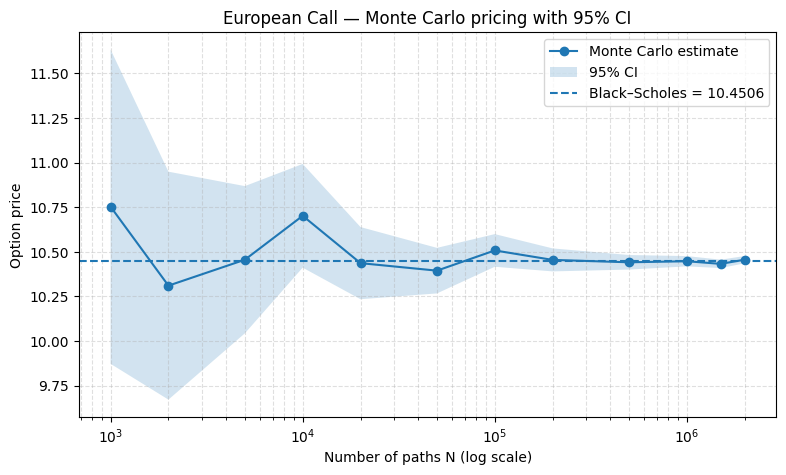

In [57]:
plt.figure(figsize=(9,5))
plt.xscale("log")

plt.plot(N_list, prices, marker="o", label="Monte Carlo estimate")
plt.fill_between(N_list, ci_low, ci_high, alpha=0.2, label="95% CI")
plt.axhline(bs_price, linestyle="--", label=f"Black–Scholes = {bs_price:.4f}")

plt.xlabel("Number of paths N (log scale)")
plt.ylabel("Option price")
plt.title("European Call — Monte Carlo pricing with 95% CI")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()


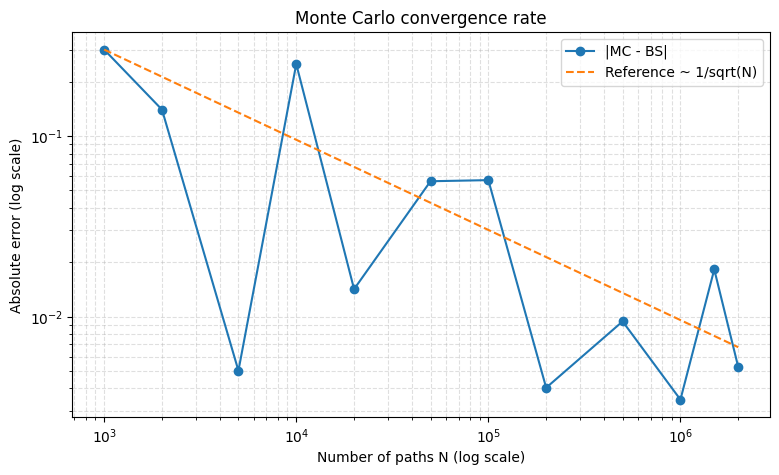

In [58]:
abs_error = np.abs(prices - bs_price)

# Référence ~ c / sqrt(N) ajustée sur le premier point
c = abs_error[0] * np.sqrt(N_list[0])
ref = c / np.sqrt(np.array(N_list))

plt.figure(figsize=(9,5))
plt.xscale("log")
plt.yscale("log")

plt.plot(N_list, abs_error, marker="o", label="|MC - BS|")
plt.plot(N_list, ref, linestyle="--", label="Reference ~ 1/sqrt(N)")

plt.xlabel("Number of paths N (log scale)")
plt.ylabel("Absolute error (log scale)")
plt.title("Monte Carlo convergence rate")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()


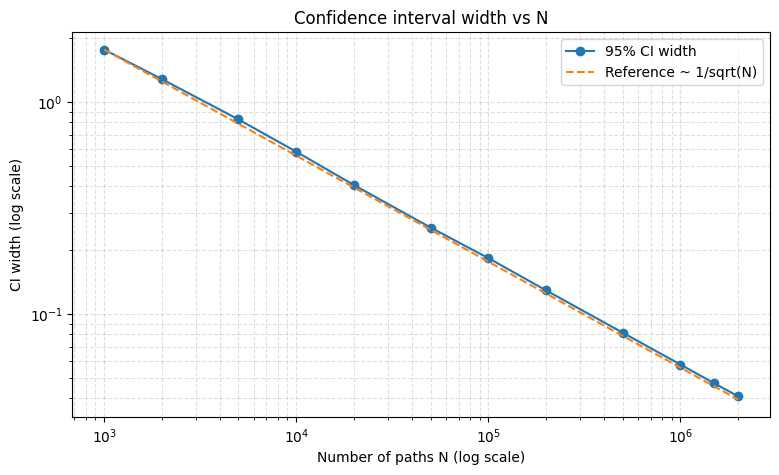

In [59]:
ci_width = ci_high - ci_low

c2 = ci_width[0] * np.sqrt(N_list[0])
ref2 = c2 / np.sqrt(np.array(N_list))

plt.figure(figsize=(9,5))
plt.xscale("log")
plt.yscale("log")

plt.plot(N_list, ci_width, marker="o", label="95% CI width")
plt.plot(N_list, ref2, linestyle="--", label="Reference ~ 1/sqrt(N)")

plt.xlabel("Number of paths N (log scale)")
plt.ylabel("CI width (log scale)")
plt.title("Confidence interval width vs N")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()


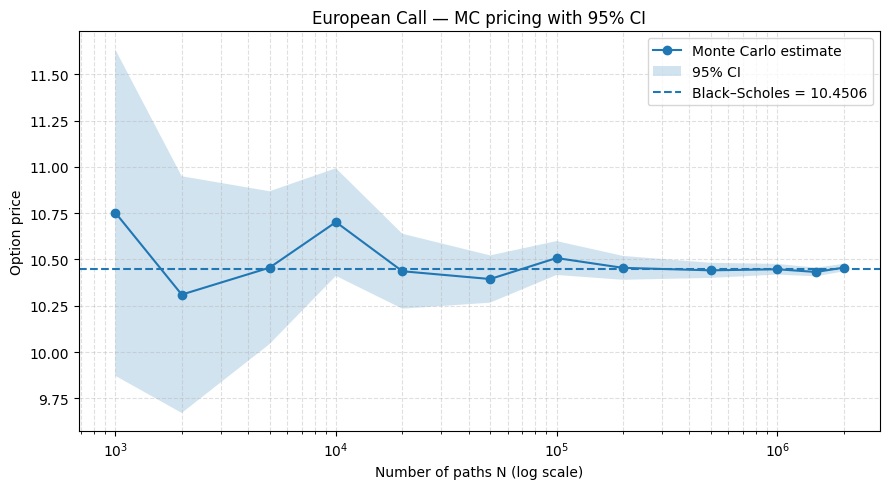

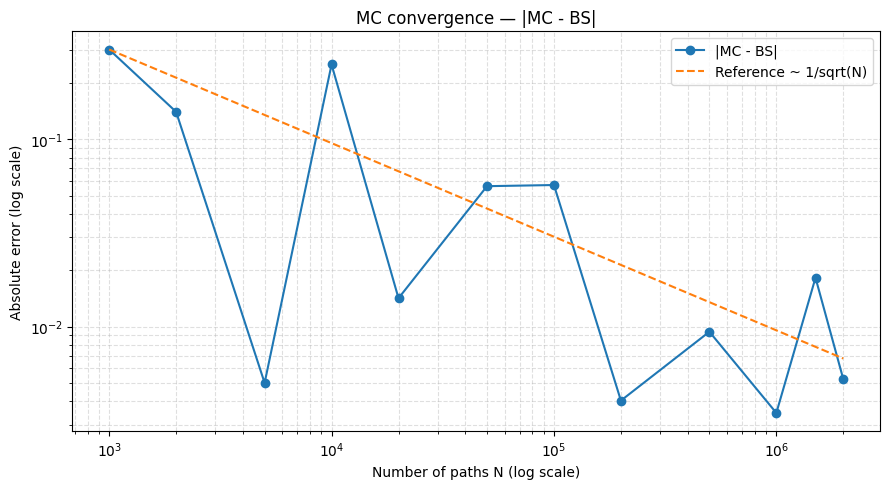

In [60]:
fig_dir = Path("..") / "figures"
fig_dir.mkdir(exist_ok=True)

# Plot 1 (recréé pour sauvegarde)
plt.figure(figsize=(9,5))
plt.xscale("log")
plt.plot(N_list, prices, marker="o", label="Monte Carlo estimate")
plt.fill_between(N_list, ci_low, ci_high, alpha=0.2, label="95% CI")
plt.axhline(bs_price, linestyle="--", label=f"Black–Scholes = {bs_price:.4f}")
plt.xlabel("Number of paths N (log scale)")
plt.ylabel("Option price")
plt.title("European Call — MC pricing with 95% CI")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(fig_dir / "mc_price_ci_vs_N.png", dpi=200)
plt.show()

# Plot 2 (recréé pour sauvegarde)
plt.figure(figsize=(9,5))
plt.xscale("log")
plt.yscale("log")
plt.plot(N_list, abs_error, marker="o", label="|MC - BS|")
plt.plot(N_list, ref, linestyle="--", label="Reference ~ 1/sqrt(N)")
plt.xlabel("Number of paths N (log scale)")
plt.ylabel("Absolute error (log scale)")
plt.title("MC convergence — |MC - BS|")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(fig_dir / "mc_abs_error_vs_N.png", dpi=200)
plt.show()
